# IT8302 Applied Machine Learning - CA2 Submission - Time Series Forecasting Models
### Submitted By: Lo Ka Fai
### Student ID: 7304896V
### Submission Date: 16 Feb 2025

# PART C: TECHNICAL PAPER

## (i) Objective:
## This exercise presents a time series forecasting approach for predicting SPY stock prices using historical data collected from yfinance. We evaluate different statistical and machine learning models, including ARIMA, SARIMA, to assess their forecasting performance. Important Time Series Forecasting features eg, Stationarity and Seasonality will be examined. Through Hyperparameters Tuning, model selection and model evaluation to aim for improving prediction accuracy.

## (ii) Information of SPY :
## The SPY ETF, which tracks the S&P 500 index, is widely used as a benchmark for market performance. Accurate predictions of SPY price movements can help traders and investors in making informed decisions. 
## Stock Dataset : spy_price.csv


## (iii) Methodology: 
## We compare the performance of ARIMA (AutoRegressive Integrated Moving Average) which is a classical statistical method for modeling time series data and SARIMA (Seasonal ARIMA) which is an extension of ARIMA that captures seasonal patterns.

## 1. Import Libraries

In [ ]:
# For automatic ARIMA model selection in time series forecasting.
!pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   --------------------------------------- 625.1/625.1 kB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------------ --------- 2.1/2.8 MB 13.1 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 10.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import os


## 2. Import Dataset and Exploratory Data Analysis

### 2.0 Fetch SPY price data (3 years) from yfinance

In [3]:
# Define the ticker symbol
ticker = "SPY"

# Define the start and end dates
start_date = "2022-10-14"
end_date = "2025-02-07"

# Fetch historical data
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Select only the Close price and rename columns
data = data[['Close']].reset_index()
data.columns = ['Date', 'SPY']

# Display the first few rows
data.head()

[*********************100%***********************]  1 of 1 completed


,Date,SPY
0,2022-10-14,346.224457
1,2022-10-17,355.121399
2,2022-10-18,359.293976
3,2022-10-19,356.747833
4,2022-10-20,353.756409


In [4]:
# Save to CSV
data.to_csv("spy_price.csv", index=False)

### Load the SPY dataset

In [5]:
df_spy = pd.read_csv("spy_price.csv")
df_spy

,Date,SPY
0,2022-10-14,346.224457
1,2022-10-17,355.121399
2,2022-10-18,359.293976
3,2022-10-19,356.747833
4,2022-10-20,353.756409
...,...,...
575,2025-01-31,601.820007
576,2025-02-03,597.770020
577,2025-02-04,601.780029
578,2025-02-05,604.219971


### 2.1 Check on dataset

### Create function "eda" to automate EDA checks

In [6]:
def eda(df):
    
    print("Perform Exploratory Data Analysis (EDA) on dataset")
    
    print("\n*** First 5 Rows ***")
    display(df.head())

    print("\n*** Last 5 Rows ***")
    display(df.tail())
    
    print("\n*** Shape of Dataset ***")
    print(df.shape)
    
    print("\n*** Info ***")
    print(df.info())

    print("\n*** Missing Values ***")
    missing_values = df.isnull().sum()
    print(missing_values)
    
    print("\n*** Statistical Summary ***")
    display(df.describe())
    
    print("\n*** Histograms ***")
    df.hist(figsize=(12,10), bins=30, edgecolor='k')
    plt.tight_layout()
    plt.show()
    
    


Perform Exploratory Data Analysis (EDA) on dataset

*** First 5 Rows ***


,Date,SPY
0,2022-10-14,346.224457
1,2022-10-17,355.121399
2,2022-10-18,359.293976
3,2022-10-19,356.747833
4,2022-10-20,353.756409



*** Last 5 Rows ***


,Date,SPY
575,2025-01-31,601.820007
576,2025-02-03,597.770020
577,2025-02-04,601.780029
578,2025-02-05,604.219971
579,2025-02-06,606.320007



*** Shape of Dataset ***
(580, 2)

*** Info ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    580 non-null    object 
 1   SPY     580 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.2+ KB
None

*** Missing Values ***
Date    0
SPY     0
dtype: int64

*** Statistical Summary ***


,SPY
count,580.000000
mean,473.463295
std,74.326489
min,346.224457
25%,404.298370
50%,453.416977
75%,540.790497
max,609.750000



*** Histograms ***


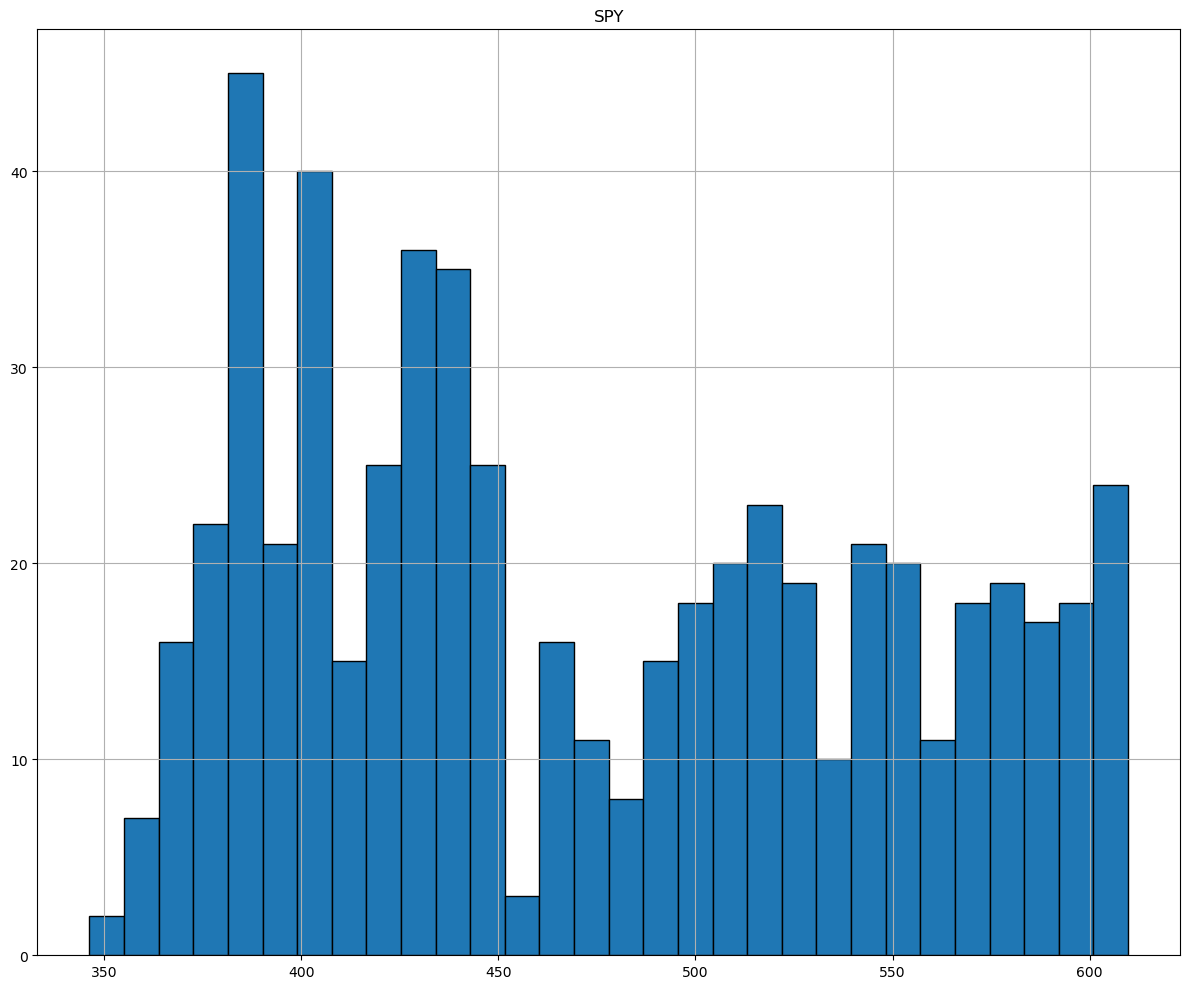

In [7]:
eda(df_spy)

### No missing data, the data is clean and cleaning is not required.
 

## 3. Preprocess Data

### 3.1 SPY - SPY index stock 

In [8]:
df_spy.head()

,Date,SPY
0,2022-10-14,346.224457
1,2022-10-17,355.121399
2,2022-10-18,359.293976
3,2022-10-19,356.747833
4,2022-10-20,353.756409


### 3.2.1 Convert Date column to datetime format and set Date column as the index for time series analysis

In [9]:
df_spy['Date'] = pd.to_datetime(df_spy['Date'])
df_spy.set_index("Date", inplace=True)

In [10]:
df_spy.head()

,SPY
Date,
2022-10-14,346.224457
2022-10-17,355.121399
2022-10-18,359.293976
2022-10-19,356.747833
2022-10-20,353.756409


### 3.2.2 Check Stationarity

### Visual check stock price on chart

<Figure size 900x600 with 0 Axes>

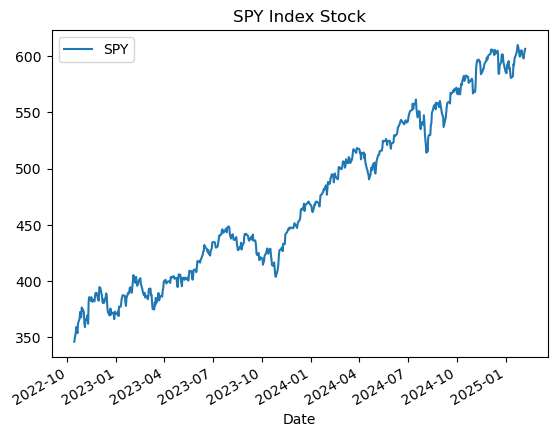

In [25]:
plt.figure(figsize=(9, 6))
df_spy.plot()
plt.title('SPY Index Stock')
plt.show()

### SPY price is trending upward and does not meet any of the stationary series properties (mean, variance, covariance), the data does not look stationary. 

### Check with Histogram 

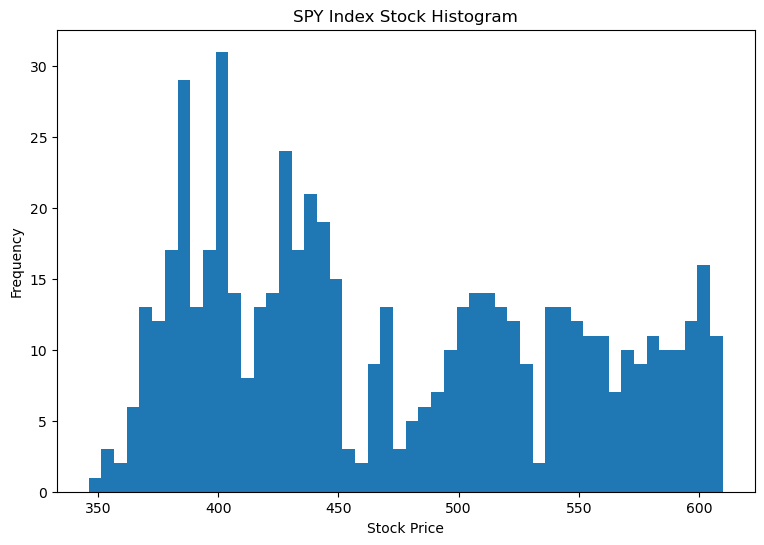

In [26]:
# Create the histogram for 'Amazon' stock data
plt.figure(figsize=(9, 6))
df_spy['SPY'].plot(kind='hist', bins=50)
plt.title('SPY Index Stock Histogram')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.show()


### It is not a typical bell curve, the data does not look stationary.

### Confirm with Augmented Dickey Fuller (ADF) test

In [27]:
result = adfuller(df_spy['SPY'])

# Output the results 
print(f'SPY No of Observations: {result[3]:}')
print(f'SPY dataset p-value: {result[1]:.4f}')

SPY No of Observations: 579
SPY dataset p-value: 0.8803


### P-value > 0.05: Fail to reject the null hypothesis (H0), the data is non-stationary.
### No of Observations means the number valid data points were used in the actual statistical test after accounting for the lags. Higher the numbers of observations used in the test, the more reliable of the test.

### 3.2.3 Apply Differencing (Make the data stationary)

SPY before differencing p-value: 0.880326
SPY after differencing p-value: 0.000000
SPY after differencing twice p-value: 0.000000




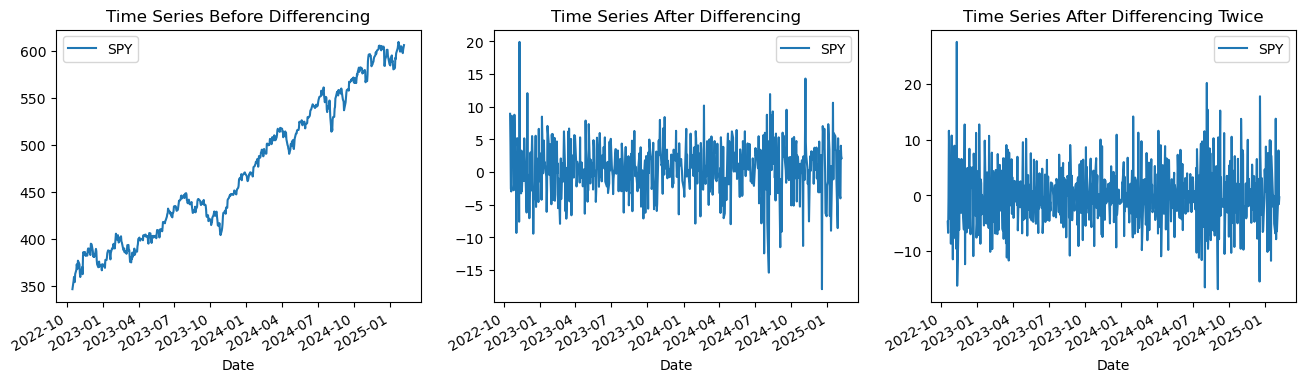

In [11]:
# Perform differencing operations
df_spy_diff = diff(df_spy['SPY'], k_diff=1)  # First differencing
df_spy_diff2 = diff(df_spy_diff, k_diff=1)  # Second differencing

# Apply ADF test to the original and differenced series
result1 = adfuller(df_spy['SPY'])  # Original series
result2 = adfuller(df_spy_diff.dropna())  # Differenced once (drop NaN)
result3 = adfuller(df_spy_diff2.dropna())  # Differenced twice (drop NaN)

# Output the results
print('SPY before differencing p-value: %f' % result1[1])
print('SPY after differencing p-value: %f' % result2[1])
print('SPY after differencing twice p-value: %f' % result3[1])

print("\n")
      
# Plot the time series before and after differencing
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

df_spy['SPY'].plot(ax=ax[0])
df_spy_diff.plot(ax=ax[1])
df_spy_diff2.plot(ax=ax[2])

ax[0].set_title('Time Series Before Differencing')
ax[1].set_title('Time Series After Differencing')
ax[2].set_title('Time Series After Differencing Twice')

# Add legend to each subplot
ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show()

### From the above results, first differencing (p-value=0.0000) is sufficient to make SPY time series data stationary.

### 3.2.4 Check Seasonality - Time Series Decomposition 
### Identify the properties of Time Series Components - (Trend, Seasonality, Random component)

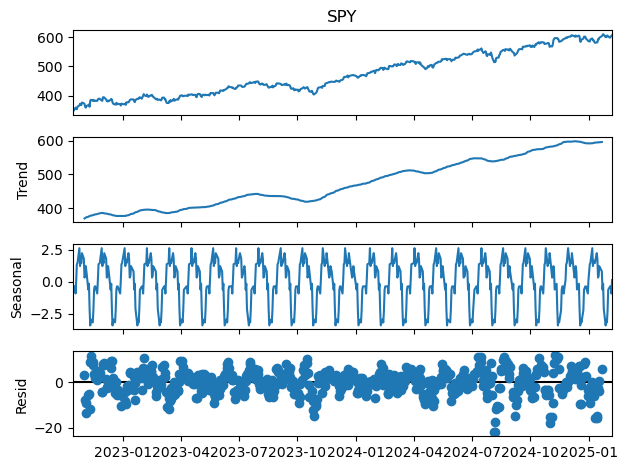

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_spy['SPY'], model='additive', period=24)  # Assuming monthly seasonality
result.plot()
plt.show()


### From the seasonal components, the time series data has seasonality. We shall use SARIMA model for training and forecasting.

### 3.2.5 ACF and PACF plot
### Use ACF and PACF plots to determine (p, d, q) and (P, D, Q, S)
### (Note: We use auto_arima for Hyperparameters Tuning later to search for the best (p, d, q) and (P, D, Q, S) instead.)

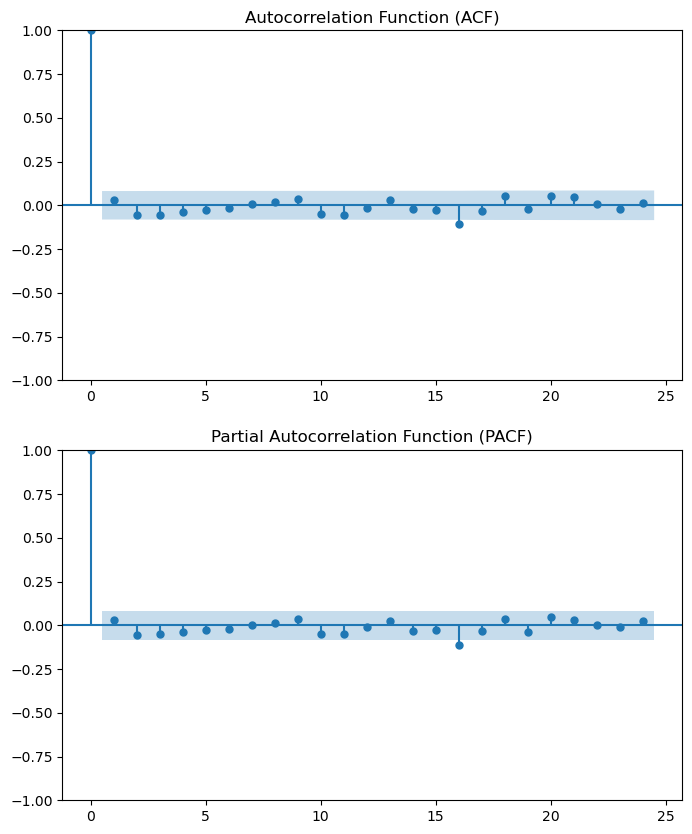

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plot ACF and PACF to determine appropriate ARIMA and seasonal parameters
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
plot_acf(df_spy_diff.dropna(), lags=24, ax=axes[0])   # ACF helps in determining the q parameter in ARIMA or SARIMA model
plot_pacf(df_spy_diff.dropna(), lags=24, ax=axes[1])  # PACF helps in determining the p parameter in ARIMA or SARIMA model
axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

## 4. Model Building

### 4.1 Split Data (Train and Test)

In [13]:
# Split data into train and test (80-20 split)
train_size = int(len(df_spy) * 0.8)
train, test = df_spy['SPY'][:train_size], df_spy['SPY'][train_size:]

In [14]:
train

Date
2022-10-14    346.224457
2022-10-17    355.121399
2022-10-18    359.293976
2022-10-19    356.747833
2022-10-20    353.756409
                 ...    
2024-08-14    540.268921
2024-08-15    549.529236
2024-08-16    550.761292
2024-08-19    556.027344
2024-08-20    555.123230
Name: SPY, Length: 464, dtype: float64

In [15]:
test

Date
2024-08-21    557.030945
2024-08-22    552.659058
2024-08-23    558.531250
2024-08-26    557.199768
2024-08-27    557.964905
                 ...    
2025-01-31    601.820007
2025-02-03    597.770020
2025-02-04    601.780029
2025-02-05    604.219971
2025-02-06    606.320007
Name: SPY, Length: 116, dtype: float64

### 4.2 Model Selection - Time Series Forecasting Model (SARIMA)

### 4.2.1 Hyperparameter Tuning with auto_arima
### To search for the best parameters for ARIMA(p,d,q) and SARIMA(P,D,Q,s) model

### Simple hyperparameter tuning

In [16]:
# Fit ARIMA or SARIMA model automatically
model = pm.auto_arima(df_spy['SPY'], seasonal=True, m=24, stepwise=True, trace=True)

# Print the summary of the model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=3.36 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=3270.066, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=3273.441, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=3273.373, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=3275.107, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=3271.996, Time=0.28 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=3271.994, Time=0.23 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=3271.543, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=3271.480, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=3273.005, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[24] intercept
Total fit time: 6.239 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                

### Comprehensive hyperparameter tuning

In [17]:
model = pm.auto_arima(df_spy['SPY'], 
                      # p and q values for the non-seasonal part of the model
                      start_p=1,                  # Starting value of p for ARIMA part (auto starts searching from this value)
                      start_q=1,                  # Starting value of q for ARIMA part (auto starts searching from this value)
                      max_p=2,                    # Maximum value of p for ARIMA part to search up to (controls the AR order)
                      max_q=2,                    # Maximum value of q for ARIMA part to search up to (controls the MA order)
                      
                      # P and Q values for the seasonal part of the model
                      start_P=1,                  # Starting value of P for seasonal AR part (auto starts searching from this value)
                      start_Q=1,                  # Starting value of Q for seasonal MA part (auto starts searching from this value)
                      max_P=2,                    # Maximum value of P for seasonal AR part to search up to (controls seasonal AR order)
                      max_Q=2,                    # Maximum value of Q for seasonal MA part to search up to (controls seasonal MA order)
                      
                      # Stationarity testing and differencing options
                      test="adf",                 # Statistical test to use for stationarity
                      d=1,                        # Non-seasonal differencing order (d=1 means first-order differencing to achieve stationarity)
                      D=1,                        # Seasonal differencing order (D=1 means first-order seasonal differencing to remove seasonal trends)
                      
                      # Seasonal settings
                      seasonal=True,              # Enable seasonal differencing and seasonal ARMA terms
                      m=24,                       # Seasonal period (m=24 means monthly seasonality with daily data with 24 trading days in a month)
                      
                      # Search strategy and output details
                      stepwise=True,              # Stepwise search for ARIMA parameters (tries a series of ARIMA models with different parameters and picks the best)
                      trace=True)                 # Display a trace of the search process to show progress and parameters being tried

# Print the summary of the model with the best parameters found
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=3.75 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=3488.788, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=3353.850, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=1.19 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=3487.599, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=3280.381, Time=2.11 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=5.37 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=3278.455, Time=1.60 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=3352.635, Time=0.37 sec
 ARIMA(0,1,0)(2,1,1)[24]             : AIC=inf, Time=3.47 sec
 ARIMA(0,1,0)(1,1,1)[24]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,1)(2,1,0)[24]             : AIC=3280.374, Time=2.09 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=3282.301, Time=4.66 sec
 ARIMA(0,1,0)(2,1,0)[24] intercept   : AIC=3280.4

### 4.3 Model Training
### Train the model with the best ARIMA(p, d, q) & SARIMA(P, D, Q, s) parameters

### sarima_model1 - Apply best (p,d,q) and (P,D,Q,S) from Simple hyperparameter tuning results

In [40]:
# Best model:  ARIMA(0,1,0)(0,0,0)[24]
# AIC:         3270.067
# SARIMAX(0, 1, 0) 


from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(df_spy['SPY'], 
                       order=(0, 1, 0),               # ARIMA(p, d, q) parameters
                       seasonal_order=(0, 1, 0, 24),  # Seasonal (P, D, Q, s)
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
                       
# Fit the model
sarima_model1 = sarima_model.fit() 

# Print model summary
print(sarima_model1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                SPY   No. Observations:                  580
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 24)   Log Likelihood               -1739.933
Date:                            Wed, 12 Feb 2025   AIC                           3481.867
Time:                                    23:06:15   BIC                           3486.184
Sample:                                         0   HQIC                          3483.553
                                            - 580                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        31.2953      1.430     21.892      0.000      28.494      34.097
Ljung-Box (L1) (Q):                

### sarima_model2 - Apply best (p,d,q) and (P,D,Q,S) from Comprehensive hyperparameter tuning results

In [18]:
# Fit SARIMA model
# s=24 for 24 days seasonality cycle 
# Best model:  ARIMA(0,1,0)(2,1,0)[24]  
# AIC:         3278.455

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(df_spy['SPY'], 
                       order=(0, 1, 0),               # ARIMA(p, d, q) parameters
                       seasonal_order=(2, 1, 0, 24),  # Seasonal (P, D, Q, s)
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
                       
# Fit the model
sarima_model2 = sarima_model.fit()

# Print model summary
print(sarima_model2.summary())    

                                     SARIMAX Results                                      
Dep. Variable:                                SPY   No. Observations:                  580
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 24)   Log Likelihood               -1463.261
Date:                            Wed, 12 Feb 2025   AIC                           2932.521
Time:                                    15:17:11   BIC                           2945.207
Sample:                                         0   HQIC                          2937.496
                                            - 580                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24      -0.6389      0.041    -15.636      0.000      -0.719      -0.559
ar.S.L48      -0.3626      0.040   

## 5. Forecasting (To forecast stock price in the next 60 days)

### 5.1 Apply sarima_model1 (Simple) for forecasting
### Best model: ARIMA(0,1,0)(0,1,0)[24]  
### AIC: 3481.867

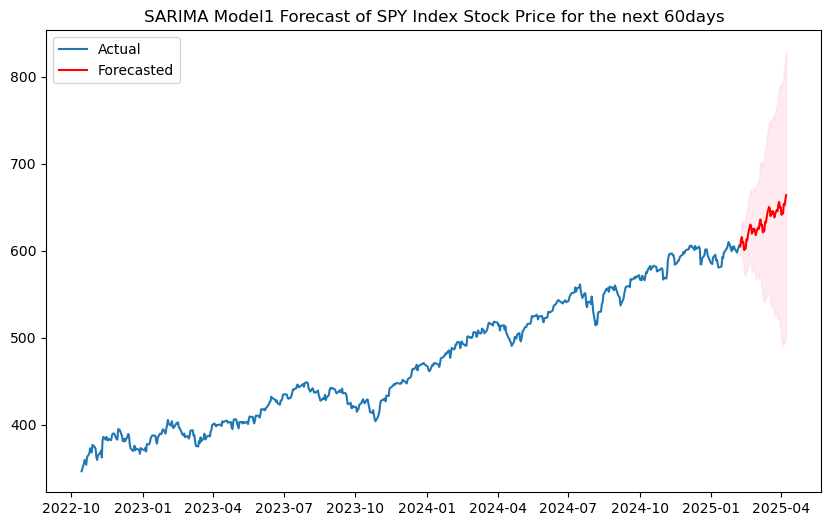

In [39]:
# Forecasting the next 60 days

forecast = sarima_model1.get_forecast(steps=60) # alpha=0.05 → 95% confidence interval (default)
forecast_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(df_spy.index, df_spy['SPY'], label='Actual')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted', color='red')
plt.fill_between(forecast_index, forecast.conf_int()['lower SPY'], forecast.conf_int()['upper SPY'], color='pink', alpha=0.3)
plt.title('SARIMA Model1 Forecast of SPY Index Stock Price for the next 60days')
plt.legend()
plt.show()

In [40]:
# Extract confidence intervals
conf_int = forecast.conf_int()

# Get the min and max forecasted price range
forecast_min = conf_int["lower SPY"].min()
forecast_max = conf_int["upper SPY"].max()

print(f"Forecasted Price Range for Next 60 Days: ${forecast_min:.2f} - ${forecast_max:.2f}")

Forecasted Price Range for Next 60 Days: $490.98 - $829.33


### 5.2 Apply sarima_model2 (Comprehensive) for forecasting
### Model: SARIMAX(0, 1, 0)x(2, 1, 0, 24)
### AIC: 2932.522

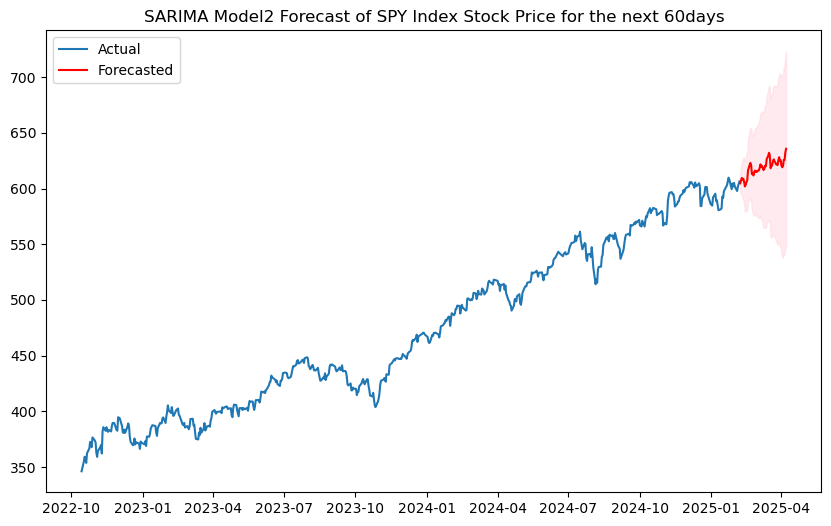

In [41]:
# Forecasting the next 60 days
forecast = sarima_model2.get_forecast(steps=60)  # alpha=0.05 → 95% confidence interval (default)
forecast_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(df_spy.index, df_spy['SPY'], label='Actual')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted', color='red')
plt.fill_between(forecast_index, forecast.conf_int()['lower SPY'], forecast.conf_int()['upper SPY'], color='pink', alpha=0.3)
plt.title('SARIMA Model2 Forecast of SPY Index Stock Price for the next 60days')
plt.legend()
plt.show()

In [42]:
# Extract confidence intervals
conf_int = forecast.conf_int()

# Get the min and max forecasted price range
forecast_min = conf_int["lower SPY"].min()
forecast_max = conf_int["upper SPY"].max()

print(f"Forecasted Price Range for Next 60 Days: ${forecast_min:.2f} - ${forecast_max:.2f}")

Forecasted Price Range for Next 60 Days: $538.01 - $723.17


### Forecasting results using the 2 SARIMA model:

### Model-1 (Simple): Predicts an uptrend in stock prices, forecasting a price range between 490.98 and 829.33 over the next 60 days.
### Model-2 (Comprehensive): Anticipates an uptrend movement as well, projecting a price range between 538.01 and 723.17 over the same period.
### The 95% confidence intervals generated by both models look reasonable. 

### 5.3 Apply arima_model for forecasting using arima results from sarima_model2
### Best model: SARIMAX(0, 1, 0)x(2, 1, 0, 24)
### AIC:  2932.522

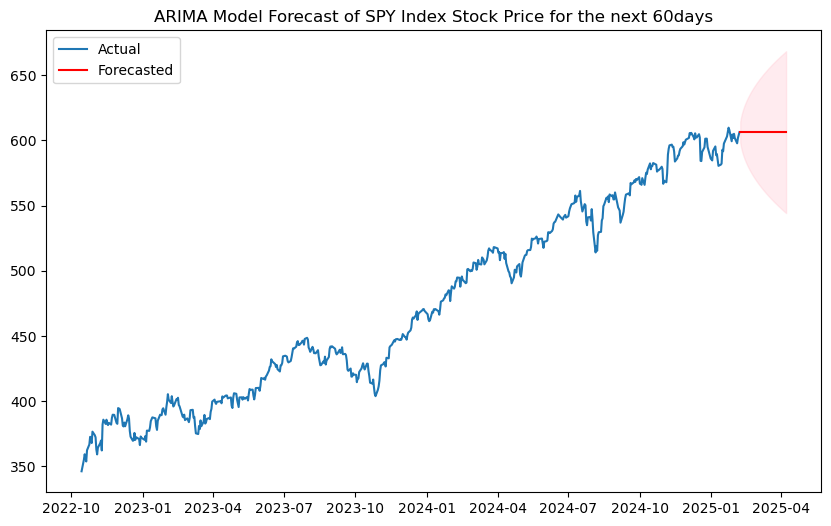

In [43]:
# Forecasting the next 60 days
# Fit ARIMA(0,1,0) model
arima_model = ARIMA(df_spy['SPY'], order=(0, 1, 0)).fit()

forecast = arima_model.get_forecast(steps=60) # alpha=0.05 → 95% confidence interval (default)

forecast_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(df_spy.index, df_spy['SPY'], label='Actual')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted', color='red')
plt.fill_between(forecast_index, forecast.conf_int()['lower SPY'], forecast.conf_int()['upper SPY'], color='pink', alpha=0.3)
plt.title('ARIMA Model Forecast of SPY Index Stock Price for the next 60days')
plt.legend()
plt.show()

In [44]:
# Extract confidence intervals
conf_int = forecast.conf_int()

# Get the min and max forecasted price range
forecast_min = conf_int["lower SPY"].min()
forecast_max = conf_int["upper SPY"].max()

print(f"Forecasted Price Range for Next 60 Days: ${forecast_min:.2f} - ${forecast_max:.2f}")

Forecasted Price Range for Next 60 Days: $544.29 - $668.35


### The ARIMA model forecasted a flat price movement for the SPY stock in the next 60 trading days.
### ARIMA model may not be suitable for forecasting seasonal data and but it works best for non-seasonal data.

### 5.4 Apply sarima_model1 to predict the actual test data

### Re-train sarima_model1 with the best model-1 parameters on Train data only

In [41]:
# Train SARIMA Model with train data only
sarima_model11 = SARIMAX(train, 
                        order=(0, 1, 0), 
                        seasonal_order=(0, 1, 0, 24)).fit()

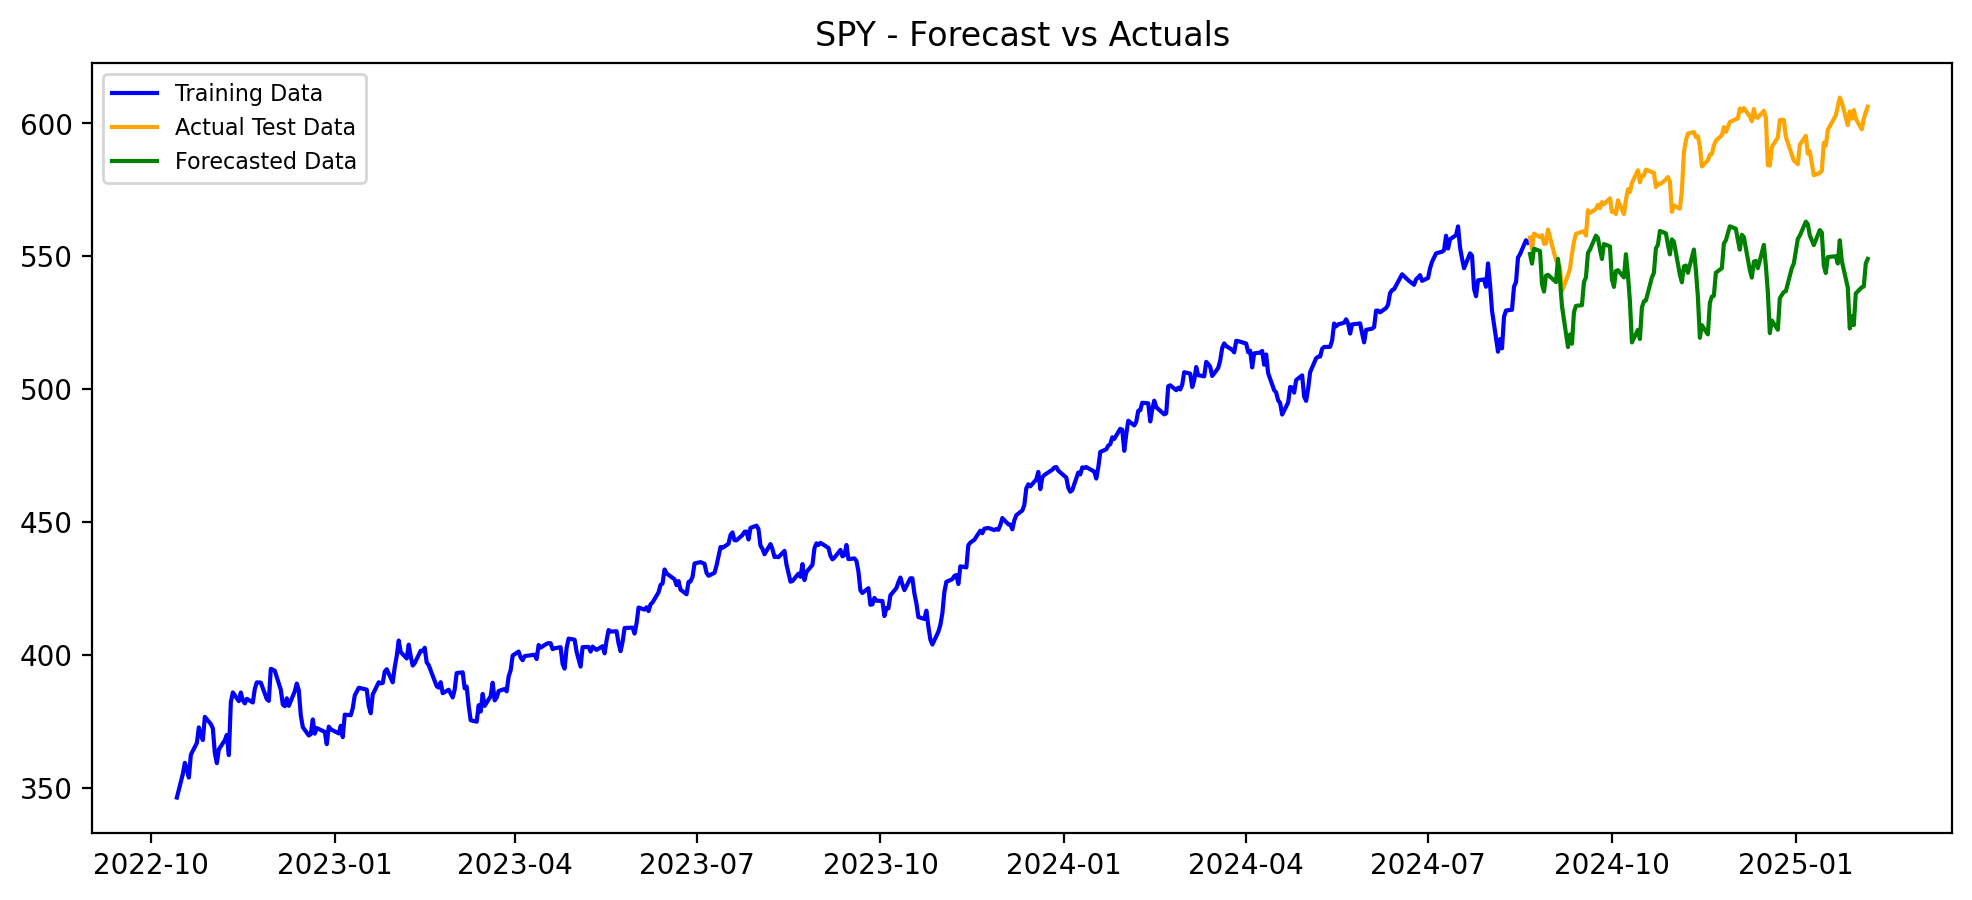

In [43]:
# Generate forecast
forecast_result = sarima_model11.get_forecast(steps=len(test), alpha=0.05)

# Extract forecasted values and confidence intervals
fc_series = forecast_result.predicted_mean
fc_series.index = test.index  # Align forecast with actual test index
conf = forecast_result.conf_int()

lower_series = pd.Series(conf["lower SPY"], index=test.index)
upper_series = pd.Series(conf["upper SPY"], index=test.index)

# Plot results
plt.figure(figsize=(12,5), dpi=200)
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Actual Test Data', color='orange')
plt.plot(fc_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, lower_series, upper_series, color='pink', alpha=0.15)

plt.title('SPY - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 5.5 Apply sarima_model2 to predict the actual test data

### Re-train sarima_model2 with the best model-2 parameters on Train data only

In [44]:
# Train SARIMA Model with train data only
sarima_model21 = SARIMAX(train, 
                        order=(0, 1, 0), 
                        seasonal_order=(2, 1, 0, 24)).fit()

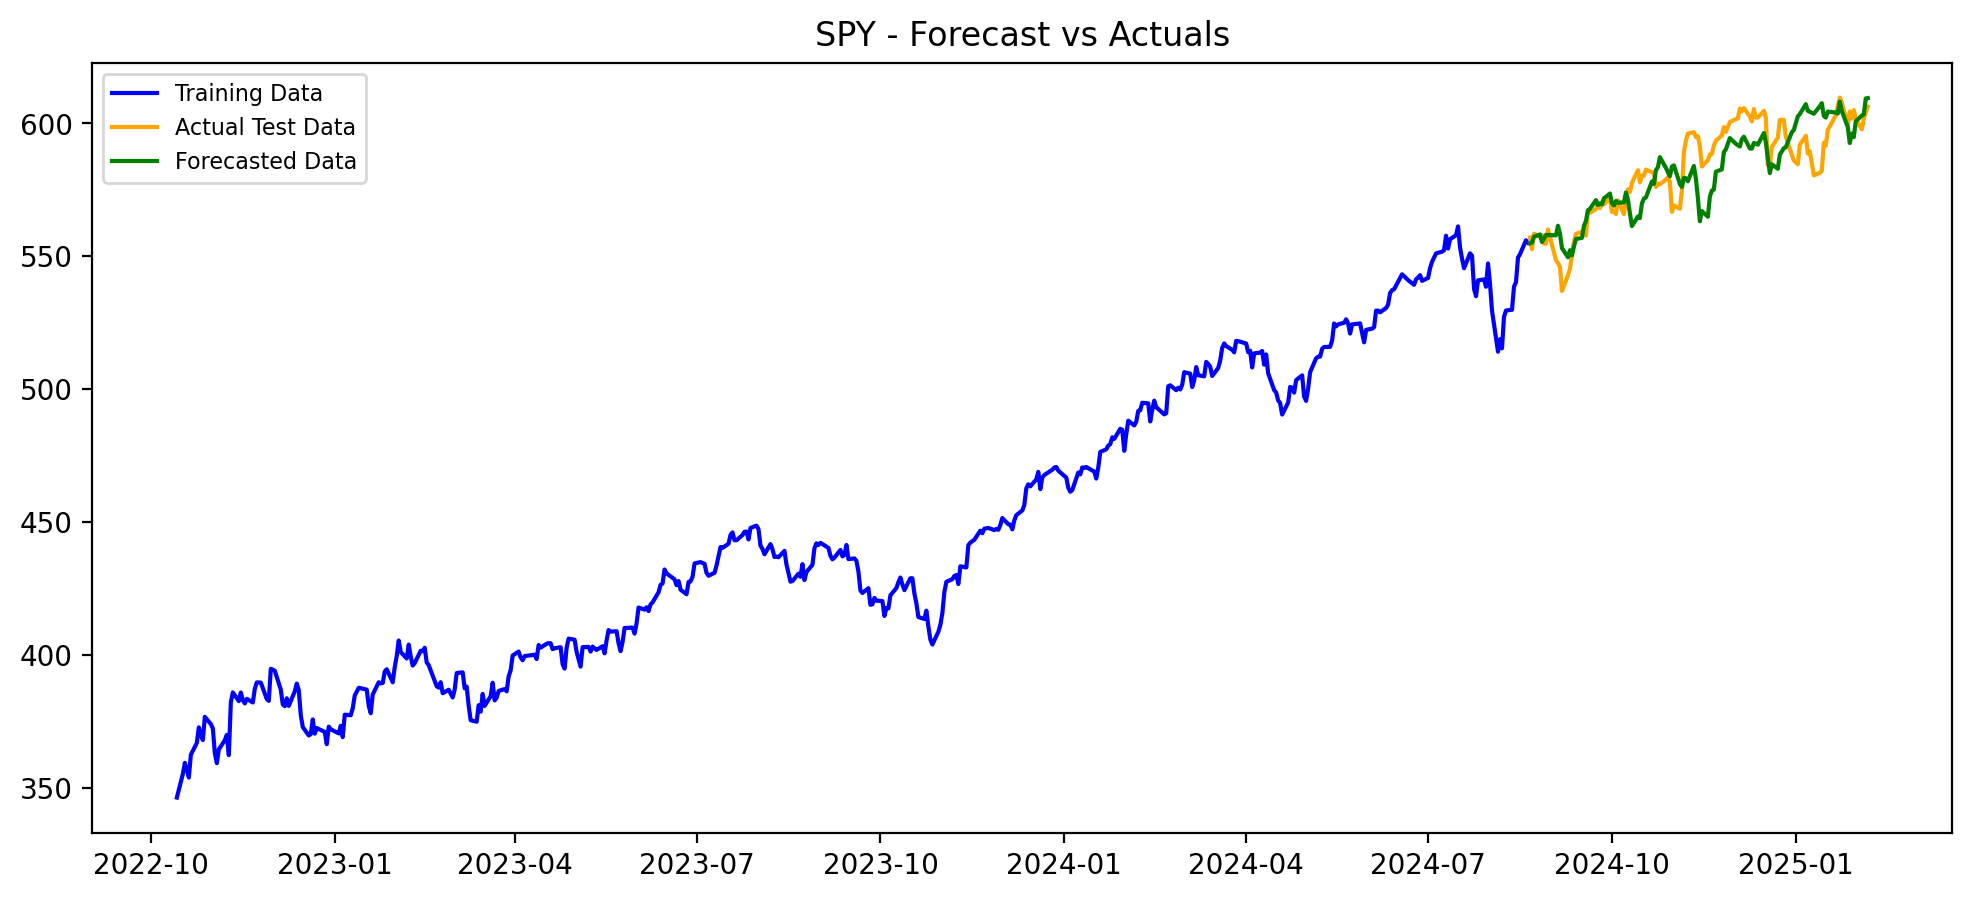

In [45]:
# Generate forecast
forecast_result = sarima_model21.get_forecast(steps=len(test), alpha=0.05)

# Extract forecasted values and confidence intervals
fc_series = forecast_result.predicted_mean
fc_series.index = test.index  # Align forecast with actual test index
conf = forecast_result.conf_int()

lower_series = pd.Series(conf["lower SPY"], index=test.index)
upper_series = pd.Series(conf["upper SPY"], index=test.index)

# Plot results
plt.figure(figsize=(12,5), dpi=200)
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Actual Test Data', color='orange')
plt.plot(fc_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, lower_series, upper_series, color='pink', alpha=0.15)

plt.title('SPY - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Model-1 predicts sideway price movement for the test data while actual fact is that test data is on the upward trend. 
### Model-2 predicts correctly the actual test data price movement.

## 6. Model Evaluation - Mean Absolute Percentage Error (MAPE)

### 6.1 Simple Model-1 (sarima_model1)

In [51]:
# Define train and test using 80% split
train_size = int(len(df_spy) * 0.8)
train, test = df_spy['SPY'][:train_size], df_spy['SPY'][train_size:]

# Get predictions
pred = sarima_model1.get_prediction(start='2022-10-14', end='2025-02-06').predicted_mean

# Ensure indices match for MAPE calculation
train_pred = pred.loc[train.index]
test_pred = pred.loc[test.index]

# To evaluate the model
from sklearn.metrics import mean_absolute_percentage_error

mape_train = mean_absolute_percentage_error(train, train_pred)
mape_test = mean_absolute_percentage_error(test, test_pred)

print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')

Model Mean Absolute Percentage Error on training data is 1.31%
Model Mean Absolute Percentage Error on testing data is 0.86%


### 6.2 Comprehensive Model-2 (sarima_model2)

In [50]:
# Get predictions
pred = sarima_model2.get_prediction(start='2022-10-14', end='2025-02-06').predicted_mean

# Ensure indices match for MAPE calculation
train_pred = pred.loc[train.index]
test_pred = pred.loc[test.index]

# To evaluate the model
from sklearn.metrics import mean_absolute_percentage_error

mape_train = mean_absolute_percentage_error(train, train_pred)
mape_test = mean_absolute_percentage_error(test, test_pred)

print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')

Model Mean Absolute Percentage Error on training data is 1.16%
Model Mean Absolute Percentage Error on testing data is 0.68%


### 6.3 ARIMA Model (arima_model)

In [52]:
# Get predictions
pred = arima_model.get_prediction(start='2022-10-14', end='2025-02-06').predicted_mean

# Ensure indices match for MAPE calculation
train_pred = pred.loc[train.index]
test_pred = pred.loc[test.index]

# To evaluate the model
from sklearn.metrics import mean_absolute_percentage_error

mape_train = mean_absolute_percentage_error(train, train_pred)
mape_test = mean_absolute_percentage_error(test, test_pred)

print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')

Model Mean Absolute Percentage Error on training data is 0.90%
Model Mean Absolute Percentage Error on testing data is 0.59%


### Verdict:

### Among the time series forecasting models tested in this assignment, the ARIMA model performs the best in terms of prediction accuracy based on the MAPE metric, achieving the lowest MAPE on both the training and testing data. 
### However, the ARIMA model may not be suitable for forecasting the stock data in this assignment, as the data exhibits seasonality, which ARIMA does not account for effectively.
### ARIMA model forecasted a horizontal price line which is rather unrealistic.
### Therefore, based on prediction accuracy and MAPE model evaluation, the best forecasting model is SARIMA_Model-2 (Comprehensive verison).

## 7. Conclusions

### Area for model improvement:
### 1. Further optimize ARIMA and SARIMA parameters for better model perofrmance. Different algorithm (ARIMA or SARIMA) and mdoel parameters (p,d,q, P,D,Q,S) work well with individual stock.
### 2. Employ more than one performance metrics for comparison, eg RMSE, R² Score.
### 3. Incorporate Technical Indicators (TA) like RSI, MACD, and Moving Averages into model training, eg use SARIMAX.
### 4. Apply TA Parameters in LSTM (Deep Learning Model).
### 5. Apply hybrid models , eg ARIMA + LSTM for better forecasting performance.
### 6. Explore more Time Series model for comparison, eg Random Forest, XGBoost.
### 7. Continue to monitor the share price development of SPY stock in the next 60 days to confirm if SARIMA Model-2 is truly able to predict an upward price movement in the range of 538.01 to 723.17.
